In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Actividad 1. Algoritmo de Giro

__________________________
Se importa el video a través de la librería OpenCV...
__________________________

In [2]:
#Se extrae el primer frame
video = cv.VideoCapture("videos/altos_peatones_automoviles.mp4")
i = 0

while(video.isOpened() and i < 1):

    ret, frame = video.read()
    if ret == False:
        break

    cv.imwrite('figuras/imagen1_' + str(i) + '.jpg', frame)
    i += 1
    
video.release()
cv.destroyAllWindows()

In [3]:
#Definir la función de binarización
def binarizacion(imagen):

    img = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gauss = cv.GaussianBlur(img_gray, (3, 3), 0)
    thr, img_thr = cv.threshold(img_gauss, 160, 255, cv.THRESH_BINARY)

    alto = img.shape[0]
    ancho = img.shape[1]
    ratio = 0.2

    img_r = cv.resize(img_thr, (480, 240), interpolation = cv.INTER_NEAREST)
    
    return(img_r)

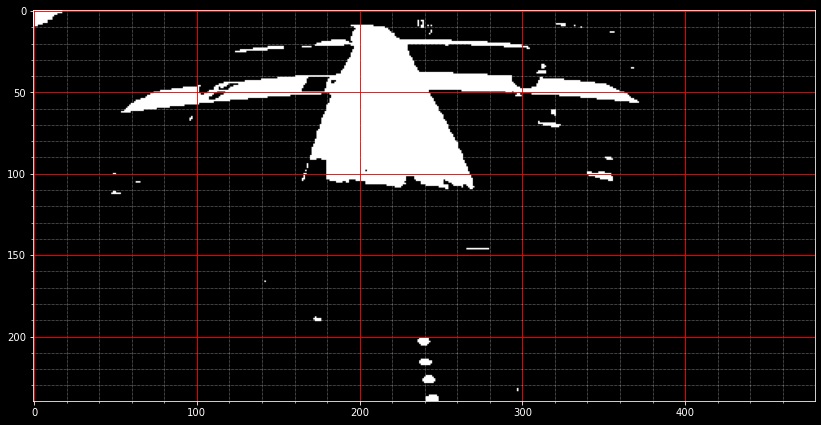

In [4]:
#Se visualiza el grid para hallar las coordenadas que serán usadas
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)

fig, ax = plt.subplots(figsize = (14, 14))

ax.imshow(img_bin, cmap = 'gray')
ax.minorticks_on()
ax.grid(which = 'major', linestyle = '-', linewidth = '0.9', color = 'red')
ax.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'white')

In [5]:
#Se definen las coordenadas para el poligono de area de interes
x1 = (170, 60)
x2 = (270, 60)
x3 = (280, 85)
x4 = (160, 85)

#Poligono de área de interés
pts_poligono = np.array([x1, x2, x3, x4], np.int32)
pts_poligono = pts_poligono.reshape((-1, 1, 2))

In [6]:
#Funcion de área de interés
def area_interes(imagen):

    pts1 = np.float32([x1, x2, x3, x4])
    pts2 = np.float32([[0, 0], [480, 0], [480, 240], [0, 240]])

    matrix = cv.getPerspectiveTransform(pts1, pts2)

    img_warp = cv.warpPerspective(imagen, matrix, (480, 240))

    return (img_warp)

In [7]:
#Función para encontrar el punto medio
def punto_medio(imagen):

    img_cercana = imagen[220:, :]

    suma_columnas = img_cercana.sum(axis = 0)

    x_pos = np.arange(len(suma_columnas))

    mid_point = int(np.dot(x_pos, suma_columnas) / np.sum(suma_columnas))
    
    return mid_point

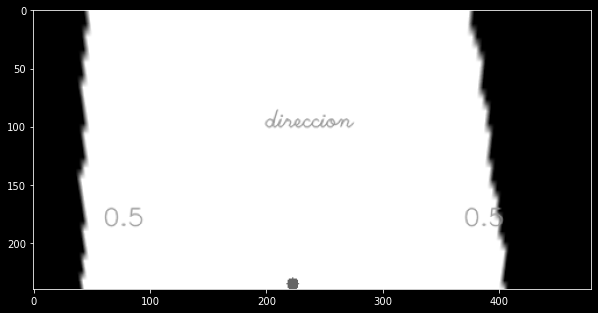

In [8]:
#Aplicamos todas las funciones
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
img_interes = area_interes(img_bin)

mid_point = punto_medio(img_interes)

#textos
text1 = str(0.50)
text2 = str(0.50)
text3 = 'direccion'

#origen de cada texto
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

#tamaño 
fontScale = 0.7

#color de la fuente
color = (150, 150, 150)

#grosor
thickness = 1

#usamos la funcion 'cv.putText()' que permitirá agregar texto
cv.putText(img_interes, text1, org1, 6, fontScale,
              color, thickness, cv.LINE_AA, False)
              
cv.putText(img_interes, text2, org2, 6, fontScale,
              color, thickness, cv.LINE_AA, False)
              
cv.putText(img_interes, text3, org3, 6, fontScale,
              color, thickness, cv.LINE_AA, False)

plt.figure(figsize = (10, 7))

cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);

plt.imshow(img_interes, cmap = 'gray')
plt.show()

In [9]:
#Funcion suma normalizada izquierda
def sum_izquierda(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, :valor_punto_medio].sum(axis=0))/(255*240*480), 2)

In [10]:
#Funcion suma normalizada derecha
def sum_derecha(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, valor_punto_medio:].sum(axis=0))/(255*240*480), 2)

In [11]:
sum_derecha(img_interes, mid_point)

0.35

In [12]:
sum_izquierda(img_interes, mid_point)

0.37

In [13]:
#Implementacion de la dirección de giro en el video 
import time

video = cv.VideoCapture('videos/carretera_nueva.mp4')
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("video", frame)

        img_bin = binarizacion(frame)
        cv.polylines(img_bin, [pts_poligono], True, (100, 100, 100))

        img_interes = area_interes(img_bin)

        mid_point = punto_medio(img_interes)

        valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
        valor_sum_derecha = sum_derecha(img_interes, mid_point)

        cv.putText(img_interes, str(valor_sum_izquierda), org1, 6, fontScale,
                   color, thickness, cv.LINE_AA, False)

        cv.putText(img_interes, str(valor_sum_derecha), org2, 6, fontScale,
                   color, thickness, cv.LINE_AA, False)

        delta = valor_sum_izquierda - valor_sum_derecha
        
        if delta > 0.07:
            movimiento = "izquierda"

        elif delta < -0.07:
            movimiento = "derecha"

        else:
            movimiento = "adelante"

        cv.putText(img_interes, movimiento, org3, 6, fontScale,
                  color, thickness, cv.LINE_AA, False)

        cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
        
        cv.imshow("video area interes", img_interes)

        time.sleep(0.02)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

video.release()
cv.destroyAllWindows()